
###**Part 1: The Encoder Decoder Network**


**Importing the Liibraries**

In [ ]:
# loading the dataset
import os
from os import listdir
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
from shutil import copyfile

from torch.utils.data import Dataset
import torch.optim as optim

import cv2
from skimage import io 
import numpy as np
from PIL import Image


**Data Preprocessing for the Model**
*   The Encoder Decoder will produce the binary mask images
*   Binary mask images cannot be compared with the annotation images given in the dataset
*   So, a contour filling algorithm is used to generate massked images from the annotation images and the file is saved. This will be used as label for training the model later on. (This was done in jupyter notebook.: screenshots attatched.)



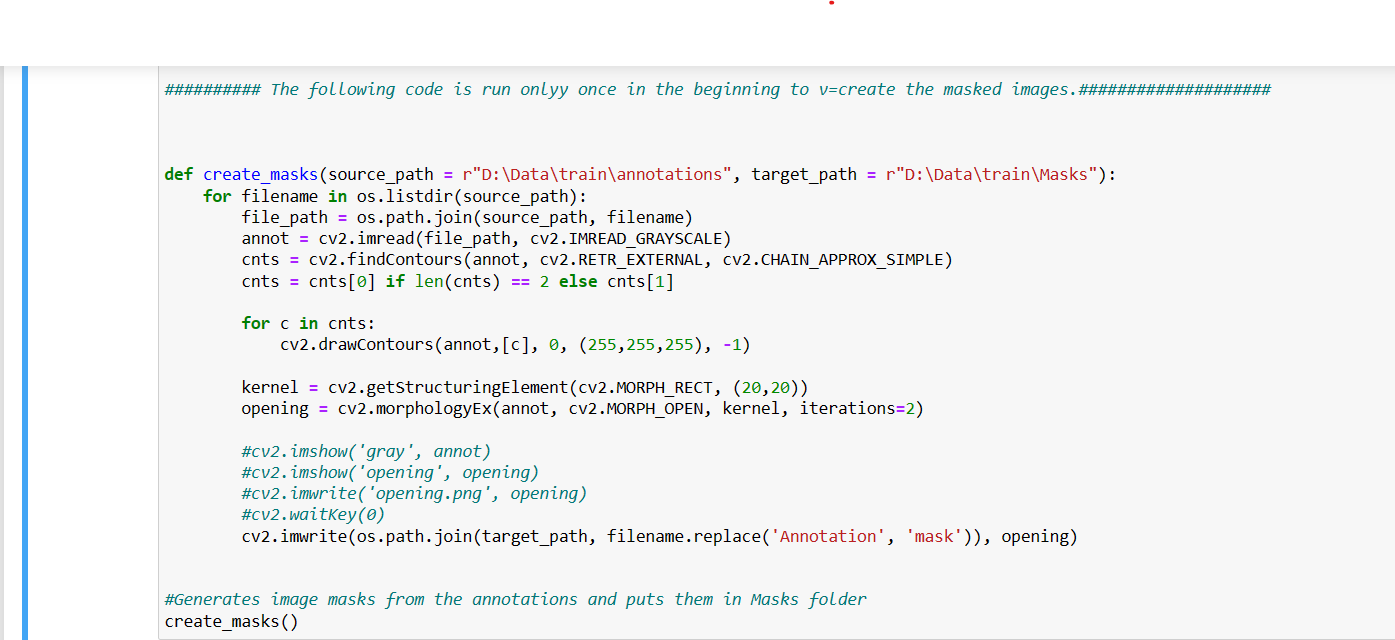

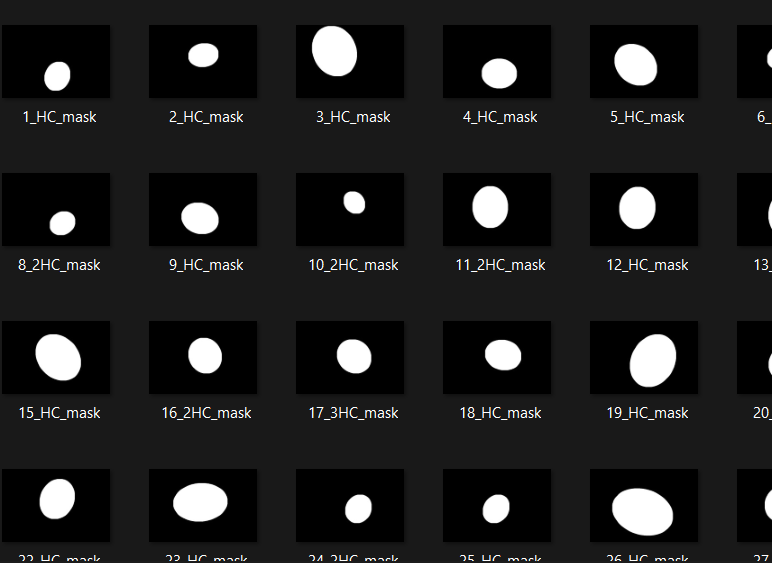












The preapared data was uploaded to kaggle and used from there.

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amarchandc/data-foetus
!unzip data-foetus.zip

**Calculating the mean and std deviation of image data**

In [ ]:
import os
import numpy as np
from PIL import Image
from torchvision.transforms import Resize

# Set the path to your dataset
dataset_path = "/content/train/images"

# Define a function to calculate the mean and standard deviation of a dataset
def calculate_mean_std(dataset_path):
    pixel_values = []
    transform = Resize((448, 448))
    for filename in os.listdir(dataset_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            img = Image.open(os.path.join(dataset_path, filename)).convert('L') # Convert to grayscale
            img = transform(img) # Resize the image to a fixed size
            pixels = np.asarray(img) / 255.0 # Convert pixel values to range [0, 1]
            pixel_values.append(pixels.flatten())
    pixel_values = np.asarray(pixel_values)
    mean = np.mean(pixel_values)
    std = np.std(pixel_values)
    return mean, std

# Call the function to calculate the mean and standard deviation of your dataset
mean, std = calculate_mean_std(dataset_path)

# Print the mean and standard deviation
print("Mean: ", mean)
print("Standard deviation: ", std)


Mean:  0.15600502400660027
Standard deviation:  0.17272706200524696


**Transformation Aplied to the images**

In [ ]:
transform = transforms.Compose([transforms.Resize((448, 448)),transforms.ToTensor(),transforms.Normalize((mean), (std))])

In [ ]:
image_folder = "/content/train/images"               #destination_folder_images
mask_folder = "/content/train/Masks"               #destination_folder_masks

class ImageDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=transform):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_folder))
        #self.mask_filenames = os.listdir(mask_folder)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_folder, image_filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = Image.open(image_path)
        
        # load mask label
        mask_filename = image_filename.replace('.png', '_mask.png')
        mask_path = os.path.join(self.mask_folder, mask_filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = Image.open(mask_path)
    

       # apply transform
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)


        return image, mask

**The Encoder Decoder Network is designed**


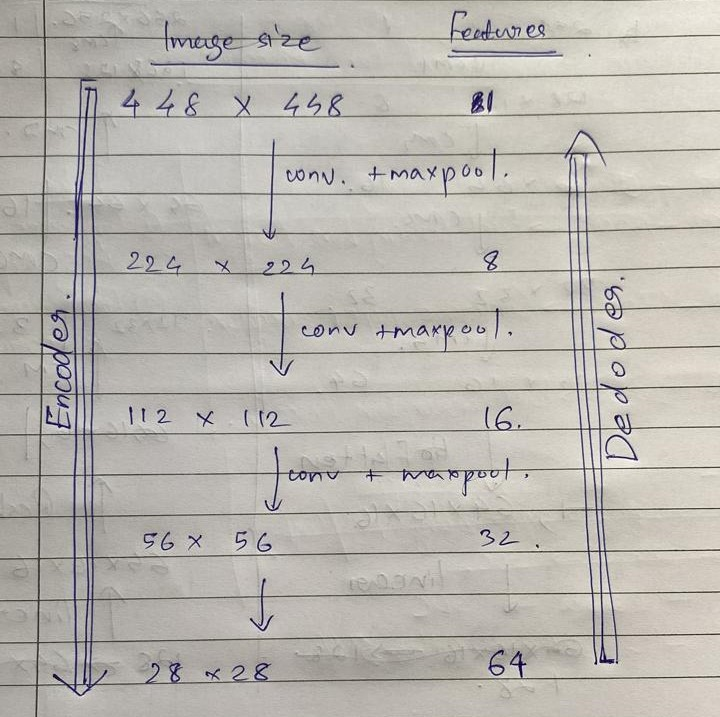

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # input channel 1, output channel 64, kernel size 3
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        # self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1) 
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.fc1 = nn.Linear(64*28*28, 128)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))  # apply conv layer with ReLU activation
        x = self.maxpool(x)  # apply max pooling        
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)       
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)

        # x = F.relu(self.conv5(x))
        # x = self.maxpool(x)
        
        # x = F.relu(self.conv6(x))
        # x = self.maxpool(x)
        
        x = x.view(-1, 64*28*28)
        x = self.fc1(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # self.conv7 = nn.ConvTranspose2d(256,128, kernel_size=3, padding=1)  # input channel 512, output channel 256, kernel size 3
        # self.conv8 = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)  # input channel 256, output channel 128, kernel size 3
        self.conv9 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)  # input channel 512, output channel 256, kernel size 3
        self.conv10 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)  # input channel 256, output channel 128, kernel size 3
        self.conv11= nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1)  # input channel 128, output channel 64, kernel size 3
        self.conv12 = nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1)  # input channel 64, output channel 1, kernel size 3
        
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.fc2   =  nn.Linear(128, 64*28*28)
        self.maxunpool = nn.MaxUnpool2d(kernel_size=2, stride=2, padding = 0)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc2(x)
        x = x.view(-1, 64, 28, 28)        
        
        # x = F.relu(self.conv7(x))
        # x = self.up(x)

        # x = F.relu(self.conv8(x))
        # x = self.up(x)
        
        x = F.relu(self.conv9(x))
        x = self.up(x)
        
        x = F.relu(self.conv10(x))
        x = self.up(x)
        
        x = F.relu(self.conv11(x))
        x = self.up(x)
             
        x = F.relu(self.conv12(x))
        x = self.up(x)

        x = self.sigmoid(x)
        return x

class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


**Dice Coefficient was Defined**

In [ ]:
def dice_coefficient(pred, target):
    smooth = 1.0
    iflat = pred.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return (2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)

class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        loss = 1 - dice_coefficient(pred, target)
        return loss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = EncoderDecoder()
batch_size = 15
#Train_Dataset =ImageDataset(r"C:\Users\LENOVO\OneDrive - IIT-Madras(IC&SR)\Courses\ID 5030\A6\Data\training_set", transform = transform)
Train_Dataset =ImageDataset(image_folder, mask_folder, transform = transform)
dataloader = torch.utils.data.DataLoader(Train_Dataset, batch_size, shuffle =True)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 15

**Training the Model**

In [ ]:
for epoch in range(num_epochs):
    for i, (image, mask) in enumerate(dataloader):
        # move the inputs to the GPU if available
        if torch.cuda.is_available():
            image = image.cuda()
            mask = mask.cuda()
            model = model.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(image)
        loss = criterion(outputs, mask)
        loss.backward()
        optimizer.step()



        # print statistics
        if i % 15 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(Train_Dataset)//batch_size, loss.item()))


Epoch [1/15], Step [1/66], Loss: 0.6416
Epoch [1/15], Step [16/66], Loss: -79.8051
Epoch [1/15], Step [31/66], Loss: -65.3950
Epoch [1/15], Step [46/66], Loss: -81.6027
Epoch [1/15], Step [61/66], Loss: -70.2153
Epoch [2/15], Step [1/66], Loss: -87.3192
Epoch [2/15], Step [16/66], Loss: -82.3312
Epoch [2/15], Step [31/66], Loss: -83.6551
Epoch [2/15], Step [46/66], Loss: -79.3233
Epoch [2/15], Step [61/66], Loss: -111.0599
Epoch [3/15], Step [1/66], Loss: -103.2070
Epoch [3/15], Step [16/66], Loss: -93.1916
Epoch [3/15], Step [31/66], Loss: -54.0035
Epoch [3/15], Step [46/66], Loss: -78.2235
Epoch [3/15], Step [61/66], Loss: -81.3476
Epoch [4/15], Step [1/66], Loss: -75.1480
Epoch [4/15], Step [16/66], Loss: -72.2087
Epoch [4/15], Step [31/66], Loss: -79.1367
Epoch [4/15], Step [46/66], Loss: -71.5427
Epoch [4/15], Step [61/66], Loss: -67.2268
Epoch [5/15], Step [1/66], Loss: -91.3431
Epoch [5/15], Step [16/66], Loss: -84.9326
Epoch [5/15], Step [31/66], Loss: -106.3545
Epoch [5/15], S

In [ ]:
#### saving the model

PATH = "/content/Saved_Model.pth"

# save the model state dictionary and the optimizer state dictionary
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

################### To load the model ##################

# PATH = "model.pth"

# # load the saved model state dictionary and optimizer state dictionary
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # put the model in evaluation mode (if needed)
# model.eval()

**Checking if the model is able to get the masked images or not**

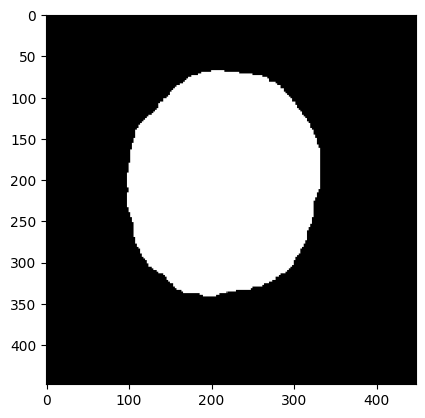

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# convert the tensor to a numpy array and transpose it to (height, width, channels)
output = outputs[1]

output = output.detach()

# convert the tensor to a numpy array and transpose it to (height, width, channels)
output = output.cpu().numpy().transpose((1, 2, 0))

# display the image using matplotlib
plt.imshow(output, cmap='gray')
plt.show()

**The encoder decoder is working Perfectly**

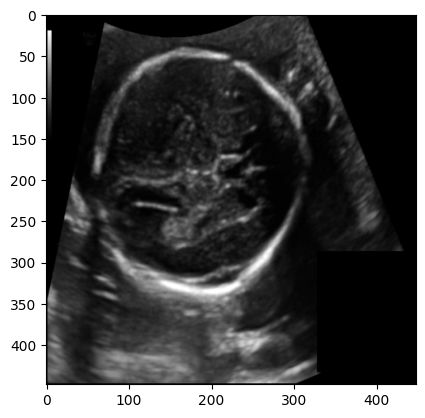

In [ ]:
# inp = image[0]

# inp = inp.detach()

# # convert the tensor to a numpy array and transpose it to (height, width, channels)
# inp = inp.cpu().numpy().transpose((1, 2, 0))

# # display the image using matplotlib
# plt.imshow(inp, cmap='gray')
# plt.show()

**Testing the model on Test Dataset**

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_folder, transform=transform):
        self.test_folder = test_folder
        self.transform = transform
        data_paths = [os.path.join(self.test_folder, f) for f in sorted(os.listdir(self.test_folder))]
        self.test_filenames = [i for i in data_paths if os.path.isfile(i)]        
        
        #self.test_filenames = os.listdir(test_folder)
    
    def __len__(self):
        return len(self.test_filenames)  
    
    def __getitem__(self, idx):
        test_filename = self.test_filenames[idx]
        test_path = os.path.join(self.test_folder, test_filename)
        #img = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
        image_test = Image.open(test_path)


       # apply transform
        if self.transform is not None:
            image_test = self.transform(image_test)


        return image_test

In [ ]:

# set the model to evaluation mode
model.eval()

# create a dataloader for the test dataset
Test_Dataset =TestDataset('/content/test_set', transform = transform)
test_dataloader = torch.utils.data.DataLoader(Test_Dataset, batch_size=1, shuffle =False)


# create a list to store the predicted masks
pred_masks = []

# disable autograd to speed up the inference
with torch.no_grad():
    # loop through the test dataloader
    for image in test_dataloader:
        # move the inputs to the GPU if available
        if torch.cuda.is_available():
           image = image.cuda()

        # forward pass
        output = model(image)
        # apply softmax to convert the output into probabilities
        #output = torch.sigmoid(output)


        # convert the tensors to numpy arrays and append to the list
        pred_masks.append((output.cpu().numpy()>0.8).astype(np.uint8))




**Testing the model generated 335 masked images. From this, we need to create the boundaries. For that, get_bound function is used**.
**The working of this function is also checked below.**

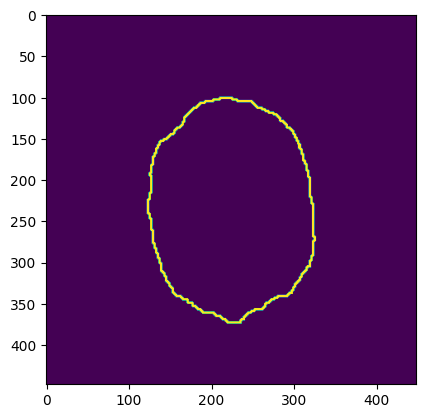

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

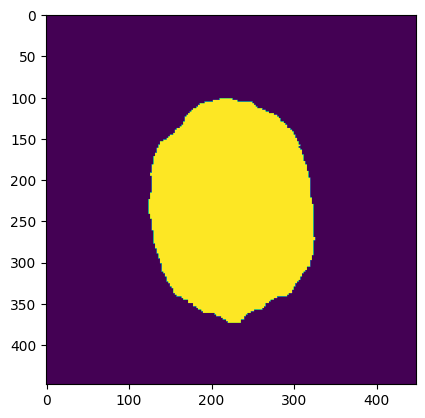

In [ ]:


def get_bound(mask_image):
    # Apply Canny edge detection to extract the object boundary
    canny_edges = cv2.Canny(mask_image, threshold1=0, threshold2=1)
    # Dilate the edges to fill in the object boundary
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(canny_edges, kernel, iterations=1)
    # Invert the mask to get the object mask
    object_mask = 1 - dilated_edges
    # Convert the NumPy array to a PyTorch tensor
    annot = torch.from_numpy(object_mask).float()

    return annot
mask = pred_masks[334][0][0]

annot = get_bound(mask)

plt.figure;
plt.imshow(annot)
plt.show()

plt.figure
plt.imshow(mask)
plt.imshow





**Now saving the annotations, generated from the masks given by the model for the whole test dataset**

In [ ]:
# now we have to save both files into the respective folders.
output_annot_folder = '/content/test_annot'
output_mask_folder = '/content/test_masks'


if not os.path.exists('/content/test_annot'):
    os.makedirs('/content/test_annot')

if not os.path.exists('/content/test_mask'):
    os.makedirs('/content/test_mask')

PATH = '/content/Saved_Model.pth'

# load the saved model state dictionary and optimizer state dictionary
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# put the model in evaluation mode (if needed)
model.eval()


test_image_folder = '/content/test_set'

# Set the path to the folder where you want to save the predicted output images
output_folder = '/content/test_annot'

# Loop through each test image in the folder
for image_name in sorted(os.listdir(test_image_folder)):
    # Load the image and convert it to a PyTorch tensor
    image = Image.open(os.path.join(test_image_folder, image_name))
    image_tensor = transform(image)
    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()
        
    # Make a prediction on the input image
    with torch.no_grad():
        masked1= model(image_tensor)  ### maask outputs.
        masked2 = masked1[0][0].numpy() #.transpose((1, 2,0))
        #img_mask = Image.fromarray(masked2)
        masked3 = cv2.convertScaleAbs(masked2)
        annot_img  = get_bound(masked3)   ### Annotation generated.
        
        mask_file_name = image_name.replace('.png', '_op_mask.png')
        annot_file_name = image_name.replace('.png', '_op_annot.png')
        # save the ndarray object to the specified file path
        file_path_annot = os.path.join(output_annot_folder, annot_file_name)
        file_path_mask = os.path.join(output_mask_folder, mask_file_name)


     #   annot_img.save(os.path.join(output_annot_folder, annot_file_name))

        img_array1 = annot_img.numpy()
        img_array2 = masked2


        # Convert the numpy array to a PIL Image object
        annot = Image.fromarray(np.uint8(img_array1))

        #Save the image with a different name
        annot.save(file_path_annot)


        # mask = Image.fromarray(np.uint8(img_array2))

        # mask.save(file_path_mask)





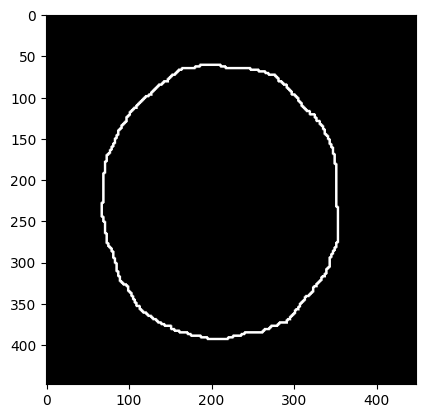

In [ ]:
        
img = Image.open("/content/test_annot/103_HC_op_annot.png")

# Convert the image to a NumPy array
img_array = np.array(img)

# Display the image
plt.imshow(img_array, cmap="gray")


**The model functioning is checked here. The test data and the masks generated are seperately plotted first. And then, the overlayed images images are generated to show the annotation on the original image itself.**

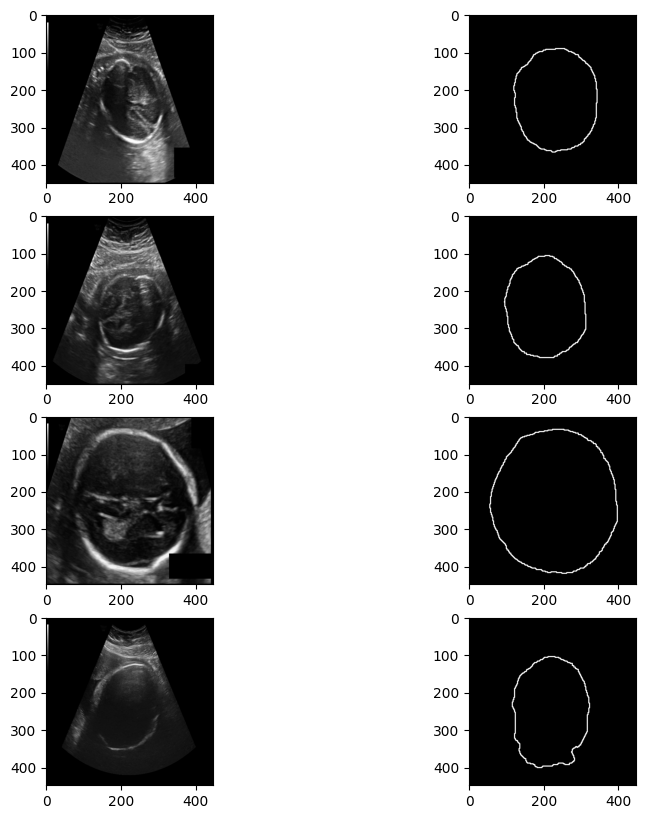

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.figure

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,10))


img1 = np.array(Image.open("/content/test_set/157_2HC.png").convert("L").resize((448, 448)))
img2 = np.array(Image.open("/content/test_set/37_2HC.png").convert("L").resize((448, 448)))
img3= np.array(Image.open("/content/test_set/55_HC.png").convert("L").resize((448, 448)))
img4 = np.array(Image.open("/content/test_set/10_2HC.png").convert("L").resize((448, 448)))
img5 = np.array(Image.open("/content/test_set/100_HC.png").convert("L").resize((448, 448)))


output1 = np.array(Image.open("/content/test_annot/157_2HC_op_annot.png").convert("L"))
output2 = np.array(Image.open("/content/test_annot/37_2HC_op_annot.png").convert("L"))
output3= np.array(Image.open("/content/test_annot/55_HC_op_annot.png").convert("L"))
output4 = np.array(Image.open("/content/test_annot/10_2HC_op_annot.png").convert("L"))
output5 = np.array(Image.open("/content/test_annot/100_HC_op_annot.png").convert("L"))


axes[0, 0].imshow(img1, cmap="gray")
axes[0, 1].imshow(output1, cmap="gray")
axes[1, 0].imshow(img5, cmap="gray")
axes[1, 1].imshow(output5, cmap="gray")
axes[2, 0].imshow(img3, cmap="gray")
axes[2, 1].imshow(output3, cmap="gray")
axes[3, 0].imshow(img4, cmap="gray")
axes[3, 1].imshow(output4, cmap="gray")


**Generating the Overlayed image from the annotation and original test images.**

In [ ]:
def Final_output(input_image_path, output_contour_path):
    from skimage import draw
    from skimage.color import gray2rgb

    img_array = np.array(Image.open(input_image_path).resize((448, 448)))
    contour_array = np.array(Image.open(output_contour_path))*255

    mask_array = np.zeros_like(img_array)
    white_pixels = np.where(contour_array == 255)

    # print the x and y coordinates of the white pixels
    y_coords = []
    x_coords = []
    for y, x in zip(*white_pixels):
        y_coords.append(y)
        x_coords.append(x)    

    mask_array[y_coords, x_coords] = 1

    green_mask = gray2rgb(mask_array)
    green_mask = np.where(green_mask > 0, [0, 0, 0], [0, 255, 0])
    img_array = gray2rgb(img_array)
    overlayed_image = img_array +(green_mask) 
   
    # display the overlayed image
    plt.imshow(overlayed_image)
    plt.show()
    return overlayed_image

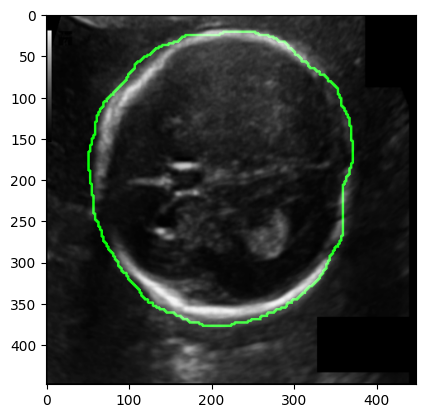

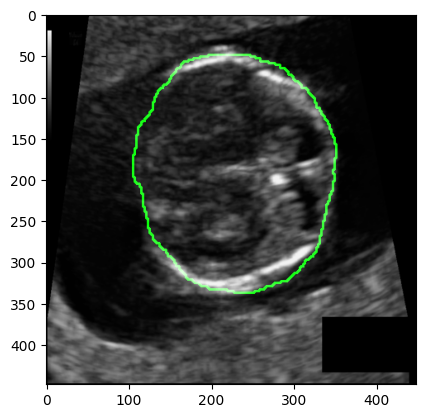

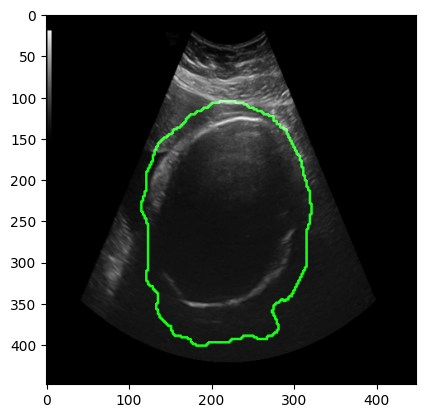

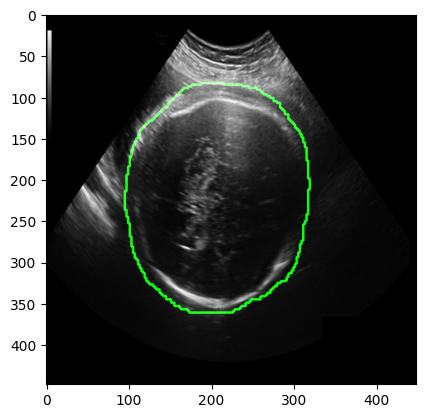

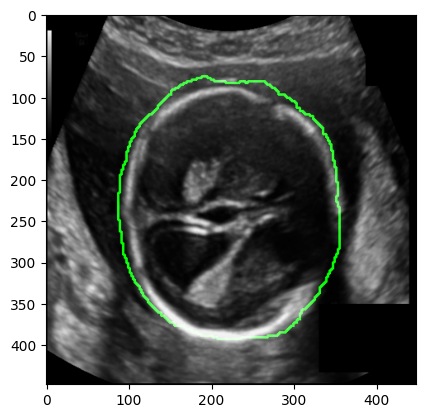

In [ ]:
p1 = Final_output('/content/test_set/131_HC.png', '/content/test_annot/131_HC_op_annot.png')
p2 = Final_output('/content/test_set/118_HC.png', '/content/test_annot/118_HC_op_annot.png')
p3 = Final_output('/content/test_set/10_2HC.png', '/content/test_annot/10_2HC_op_annot.png')
p4 = Final_output('/content/test_set/248_HC.png', '/content/test_annot/248_HC_op_annot.png')
p5 = Final_output('/content/test_set/326_HC.png', '/content/test_annot/326_HC_op_annot.png')


**The model is performing well, predicting and marking the fetal heads.**

##**Part 2: UNET Model**

In [ ]:
!unzip '/content/fetal-head-circumference-data.zip'
#!unzip '/content/data-foetus.zip'

In [ ]:
from sklearn.model_selection import train_test_split
import os

In [ ]:
from sklearn.model_selection import train_test_split
import os

image_main = '/content/Fetal Head Circumference/train_set/Images'
mask_main = '/content/Fetal Head Circumference/train_set/Annotation'

#image_main = '/content/train/images'
#mask_main = '/content/train/Masks'
images = sorted(os.listdir(image_main))
masks = sorted(os.listdir(mask_main))

In [ ]:
images[0]

'000_HC.png'

In [ ]:
data_dir = os.listdir('/content/Fetal Head Circumference/train_set')
#data_dir = os.listdir('/content/train')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
import cv2
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

**splitting into train and validation data**

In [ ]:
train_x , val_x , train_y, val_y = train_test_split(images, masks , test_size = 0.2 , random_state = 21)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

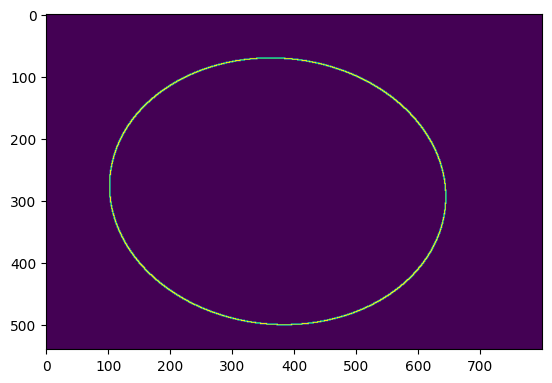

In [ ]:
img_path2 = os.path.join(mask_main, train_y[100])
c= Image.open(img_path2)

plt.imshow(Image.open(img_path2))

**converting input image into desired format and transforming** 

In [ ]:
#dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
  def __init__(self, data_dir, image_main, train_x, mask_main, train_y, transforms = None):
    self.data_dir = data_dir
    self.image_main = image_main
    self.train_x = train_x
    self.mask_main = mask_main
    self.train_y = train_y
    self.transforms = transforms
  def __len__(self):
    return len(self.train_x)
  def __getitem__(self, index):
    img_path = os.path.join(self.image_main, self.train_x[index])
    mask_path = os.path.join(self.mask_main, self.train_y[index])
    image = (Image.open(img_path).convert('RGB'))
    mask = (Image.open(mask_path).convert('L')) #dtype = np.float32)
    mask = ndi.binary_fill_holes(mask) 
    mask = (Image.open(mask_path).convert('L'))
    mask[mask == 255.0] = 1.0
    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)

    return image, mask

In [ ]:
#dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
  def __init__(self, data_dir, image_main, train_x, mask_main, train_y, transforms = None):
    self.data_dir = data_dir
    self.image_main = image_main
    self.train_x = train_x
    self.mask_main = mask_main
    self.train_y = train_y
    self.transforms = transforms
  
  def __len__(self):
    return len(self.train_x)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_main, self.train_x[index])
    mask_path = os.path.join(self.mask_main, self.train_y[index])
    image = (Image.open(img_path).convert('RGB'))
    mask = (Image.open(mask_path).convert('L')) #dtype = np.float32)
    mask = ndi.binary_fill_holes(mask) 
    mask = (Image.open(mask_path).convert('RGB'))

    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)
  
    return image, mask

In [ ]:
#transforms
train_transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.2, 0.2, 0.2])]) 
val_transform = transforms.Compose([
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.2, 0.2, 0.2])]) 

In [ ]:
train_dataset = CarvanaDataset(data_dir, image_main, train_x, mask_main, train_y, transforms = train_transform)
val_dataset = CarvanaDataset(data_dir, image_main, val_x, mask_main, val_y, transforms = val_transform)

In [ ]:
#dataloader
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)

##unet##

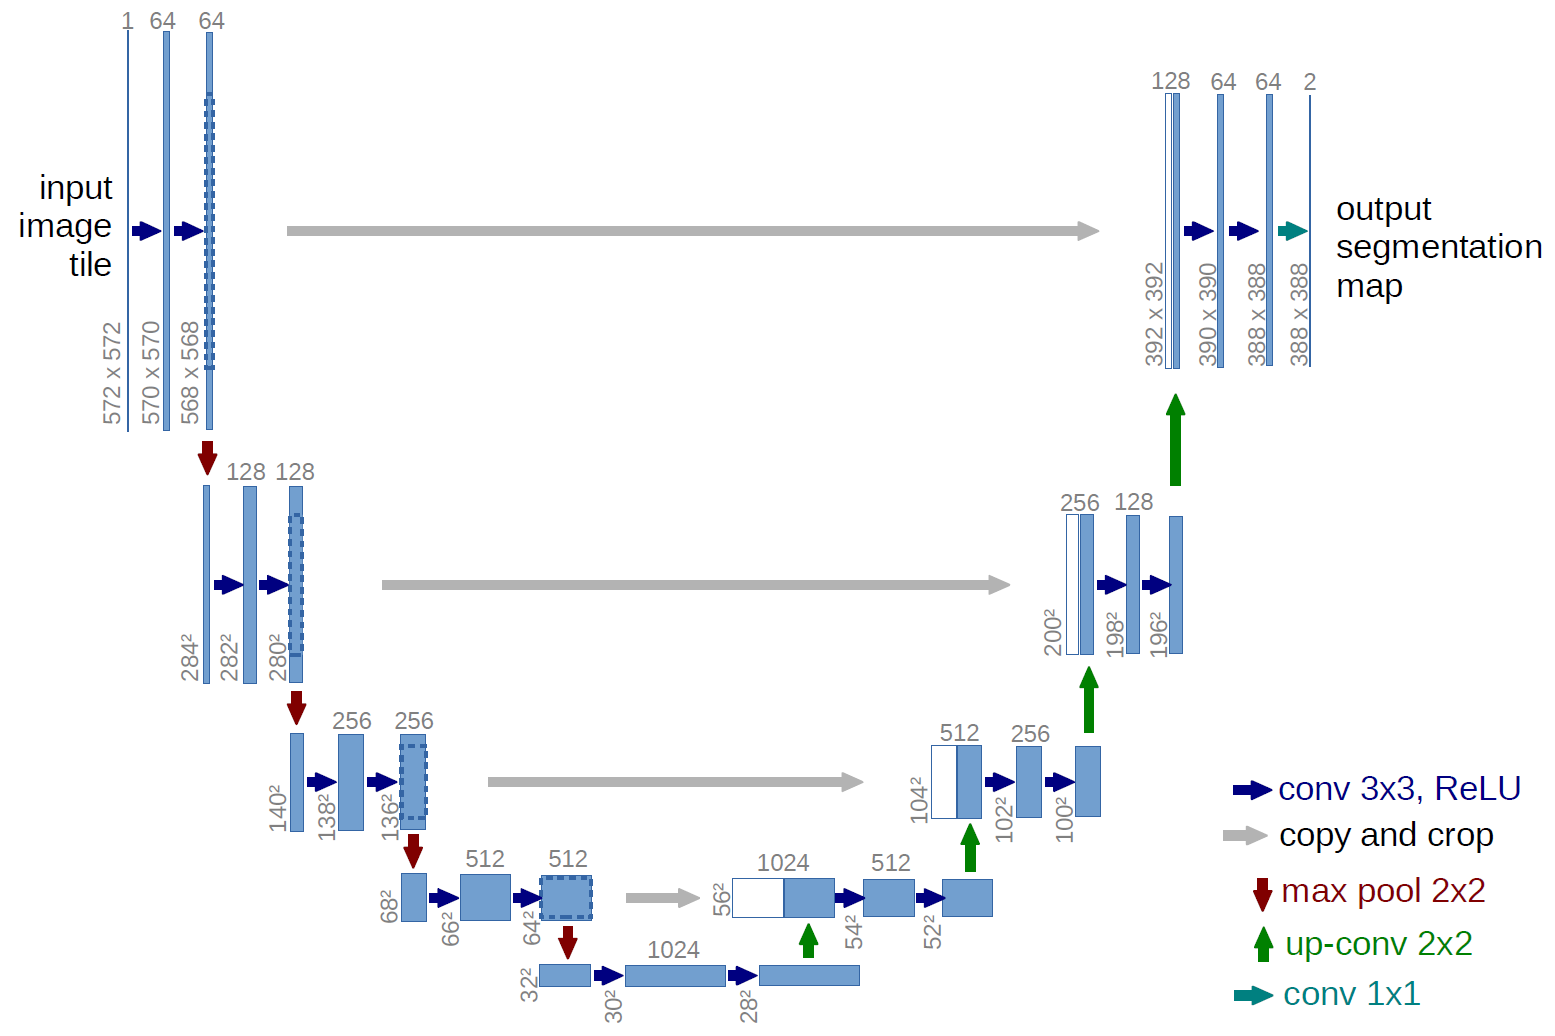

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias= False),
        nn.BatchNorm2d(out_channels),  
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias= False),
        nn.BatchNorm2d(out_channels),  
        nn.ReLU(inplace= True),
    )

  def forward(self, x):
    return self.conv(x)

In [ ]:
class UNET(nn.Module):
  def __init__(
      self, in_channels= 3, out_channels= 1, features= [64,128,256,512], 
  ):
    super(UNET, self).__init__()
    self.downs= nn.ModuleList()
    self.ups= nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride= 2)

    #down part
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels= feature

    #for up part
    for feature in reversed(features):
      #skip connect
      self.ups.append(
          nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
      )
      #up conv 
      self.ups.append(DoubleConv(feature*2, feature))
    
    #bottom layer flat
    self.bottleneck= DoubleConv(features[-1], features[-1]*2)
    self.final_conv= nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x= down(x)
      skip_connections.append(x)
      x= self.pool(x)

    x= self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x= self.ups[idx](x)
      skip_connection= skip_connections[idx//2]

      #if input is not divisible by 16...it would not concatenate due to size diff
      if x.shape != skip_connection.shape:
        x= TF.resize(x, size= skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x= self.ups[idx+1](concat_skip)

    return self.final_conv(x)

def test():
  x = torch.randn((3, 1, 160, 160))
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == '__main__':
  test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [ ]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum()

In [ ]:
model = UNET(in_channels=3, out_channels=1)   
#criterion = nn.BCEWithLogitsLoss()
criterion = dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

**training the model**

In [ ]:
num_epoch = 10
train_loss=[]
val_loss=[]
for epoch in range(num_epoch):
  running_loss= 0.0
  model.train()

  for i, (images, masks) in enumerate(train_loader):
    
    optimizer.zero_grad()
    outputs= model(images)
    loss, dice_coeff = criterion(outputs, masks)
    #loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    #if (i) % 10 ==0:
    #print(f'epoch [{i}/{num_epoch}], loss: {loss.item()/50:.4f}, dice coeff:{dice_coeff.item()/50:.4f}')  #len/batch_size

  with torch.no_grad():
    val_loss = 0.0
    dice_coeff_val=0.0
    model.eval()
    for images_val, masks_val in val_loader:
        output_val = model(images_val)
        val_loss2,dice_coeff_val = criterion(output_val, masks_val)
        val_loss+=val_loss2
    print(dice_coeff_val)
  epoch_loss = running_loss/len(train_loader)
  val_epoch_loss = val_loss/len(val_loader)
  print(f"Epoch [{epoch+1}/{num_epoch}], train dice loss: {epoch_loss/50:.4f}, validation dice loss: {val_epoch_loss/50:.4f}")

tensor(-8.8369)
Epoch [1/10], train dice loss: 2.3022, validation dice loss: 2.0655
tensor(-46.1442)
Epoch [2/10], train dice loss: 2.7415, validation dice loss: 2.7002
tensor(-46.3440)
Epoch [3/10], train dice loss: 2.8091, validation dice loss: 2.7035
tensor(-44.9969)
Epoch [4/10], train dice loss: 2.7938, validation dice loss: 2.6677
tensor(-16.3533)
Epoch [5/10], train dice loss: 2.6239, validation dice loss: 3.6231
tensor(-45.9055)
Epoch [6/10], train dice loss: 2.7169, validation dice loss: 2.6918
tensor(-46.2127)
Epoch [7/10], train dice loss: 2.8059, validation dice loss: 2.6994
tensor(-45.7852)
Epoch [8/10], train dice loss: 2.7994, validation dice loss: 2.6884
tensor(-45.5671)
Epoch [9/10], train dice loss: 2.7843, validation dice loss: 2.6734
tensor(-45.2592)
Epoch [10/10], train dice loss: 2.7650, validation dice loss: 2.6628


In [ ]:
num_epoch = 10
for epoch in range(num_epoch):
      running_loss= 0.0
      model.train()

      for i, (images, masks) in enumerate(train_loader):
    
        optimizer.zero_grad()
        outputs= model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    #if (i+1) % 2 ==0:
    #print(f'epoch [{epoch+1}/{num_epoch}], loss: {loss.item():.4f}')

      with torch.no_grad():
        val_loss = 0.0
        model.eval()
        for images_val, masks_val in val_loader:
            output_val = model(images_val)
            val_loss += criterion(output_val, masks_val).item()

      epoch_loss = running_loss/len(train_loader)
      val_epoch_loss = val_loss/len(val_loader)
      print(f"Epoch [{epoch+1}/{num_epoch}], train loss: {epoch_loss:.4f}, validation loss: {val_epoch_loss:.4f}")

Epoch [1/10], train loss: 0.0603, validation loss: 0.0429
Epoch [2/10], train loss: 0.0346, validation loss: 0.0369
Epoch [3/10], train loss: 0.0332, validation loss: 0.0323
Epoch [4/10], train loss: 0.0313, validation loss: 0.0326
Epoch [5/10], train loss: 0.0296, validation loss: 0.0283
Epoch [6/10], train loss: 0.0285, validation loss: 0.0274
Epoch [7/10], train loss: 0.0279, validation loss: 0.0273
Epoch [8/10], train loss: 0.0269, validation loss: 0.0300
Epoch [9/10], train loss: 0.0266, validation loss: 0.0260
Epoch [10/10], train loss: 0.0265, validation loss: 0.0262


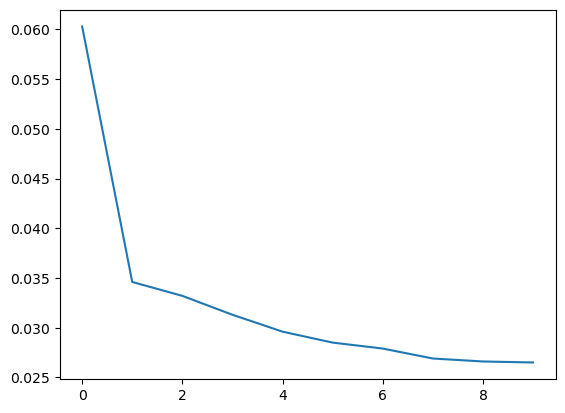

In [ ]:
plt.plot(range(10), train_loss)

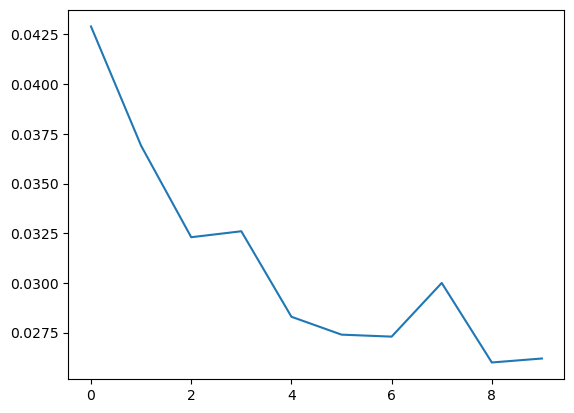

In [ ]:
plt.plot(range(10), val_loss)

In [ ]:
torch.save(model.state_dict(),'model.pth')

In [ ]:
path = F'/content/model.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

**test dataset**


In [ ]:
images_test = sorted(os.listdir('/content//test_set'))

In [ ]:
test_main = '/content//test_set'

In [ ]:
images_test[0]

'000_HC.png'

In [ ]:
test_transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((160,160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2, 0.2, 0.2], std=[0.2, 0.2, 0.2])
])

In [ ]:
#dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch

class testDataset(Dataset):
  def __init__(self, data_dir, image_main, train_x, transforms = test_transform):
    self.data_dir = data_dir
    self.image_main = image_main
    self.train_x = train_x
    self.transforms = transforms
  
  def __len__(self):
    return len(self.train_x)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_main, self.train_x[index])
    image = (Image.open(img_path).convert('RGB'))
    if self.transforms is not None:
      image = self.transforms(image)
    return image

In [ ]:
test_dataset = testDataset(data_dir, test_main, images_test, transforms = test_transform)

In [ ]:
test_dataset

In [ ]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model.to(device)
#tensor.to(device)

In [ ]:
model.eval()
predictions = []
with torch.no_grad():
  for inputs in test_loader:
    outputst = model(inputs)
    outputs = torch.sigmoid(outputst)
    predictions.append((outputs.cpu().numpy()>0.009).astype(np.uint8) )
predictions = np.concatenate(predictions, axis=0) 

In [ ]:
predictions1= np.transpose(predictions, (0, 2, 3, 1))

In [ ]:
#predictions1= predictions[3].squeeze(axis=1)
#predictions1= predictions[3].squeeze(axis=0)

In [ ]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        mode= 'subpixel',
                        outline_color=(1,0.5,0),
                        color=(1,1,0))
    plt.imshow(img_mask)
    

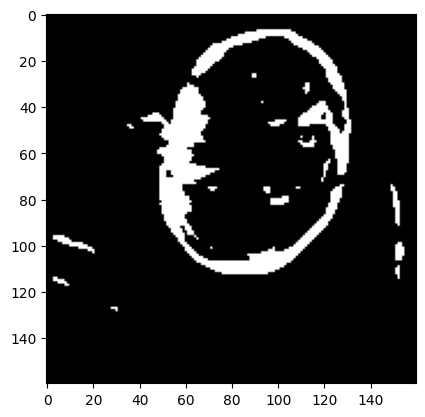

In [ ]:
mask = ndi.binary_fill_holes(predictions1[122]) 
plt.imshow(mask, cmap= 'gray')
plt.show()
#show_img_mask(test_dataset[3], mask)

In [ ]:
#h=[0,124]

original mask on image

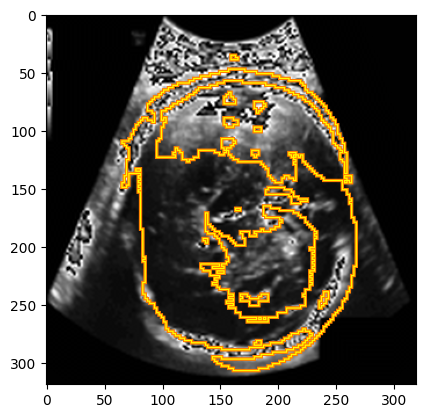

In [ ]:
show_img_mask(test_dataset[39], predictions1[39])

processed mask

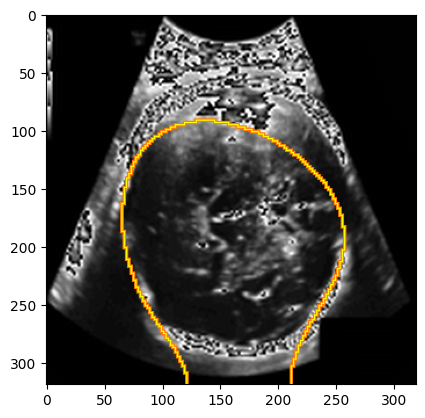

In [ ]:
v1 = 39
#mask = ndi.binary_fill_holes(predictions1[1])
threshold = 0.9
binary_mask = predictions1[v1] > threshold

# Invert binary mask
inverted_mask = 1 - binary_mask

# Apply Gaussian filter to inverted mask
sigma = 25
filtered_mask = cv2.GaussianBlur(inverted_mask.astype(np.float32), (0, 0), sigma)

# Threshold the filtered mask to get binary mask
threshold2 = 0.68
filtered_binary_mask = filtered_mask > threshold2

# Invert binary mask to get final filled mask
filled_mask = 1 - filtered_binary_mask
fil_mask = filled_mask.astype(np.uint8)

show_img_mask(test_dataset[v1], fil_mask)

another example

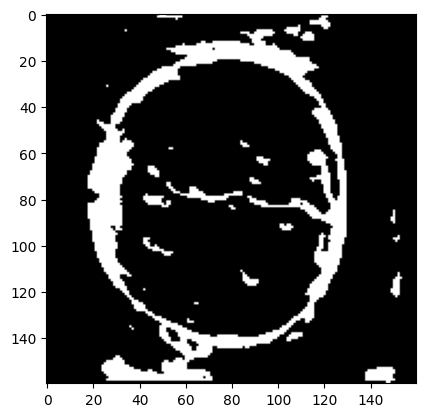

In [ ]:
mask = ndi.binary_fill_holes(predictions1[10]) 
plt.imshow(mask, cmap= 'gray')
plt.show()
#show_img_mask(test_dataset[3], mask)

In [ ]:
#h=[0,124]

original mask on image

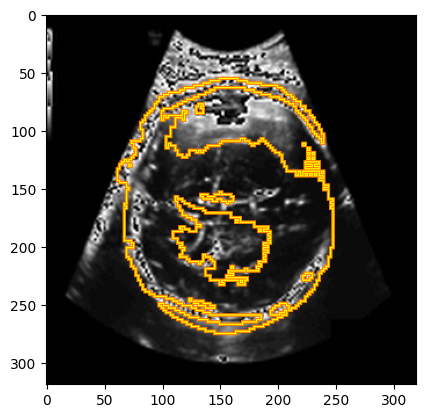

In [ ]:
show_img_mask(test_dataset[0], predictions1[0])

processed mask

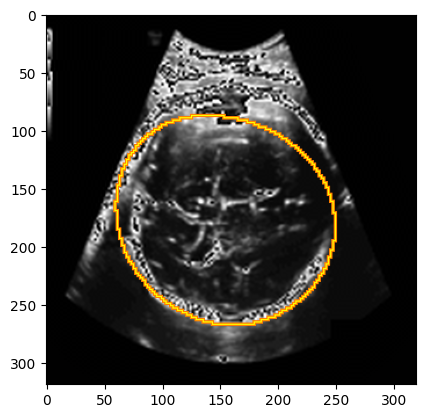

In [ ]:
v=0
#mask = ndi.binary_fill_holes(predictions1[1])
threshold = 0.9
binary_mask = predictions1[v] > threshold

# Invert binary mask
inverted_mask = 1 - binary_mask

# Apply Gaussian filter to inverted mask
sigma = 25
filtered_mask = cv2.GaussianBlur(inverted_mask.astype(np.float32), (0, 0), sigma)

# Threshold the filtered mask to get binary mask
threshold2 = 0.68
filtered_binary_mask = filtered_mask > threshold2

# Invert binary mask to get final filled mask
filled_mask = 1 - filtered_binary_mask
fil_mask = filled_mask.astype(np.uint8)

show_img_mask(test_dataset[v], fil_mask)

**It seems that the unet model needs more epochs/ training to reach a better performance.**